# Binomial Method

Using an iterative process and numerous periods to value American options, the binomial option pricing model values options. Each execution of the model has two potential outcomes: a move up or a move down that follows a binomial tree.

In [1]:
import numpy as np
import scipy
import scipy.linalg as la
import scipy.stats as si
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.linalg import hilbert, inv, norm
from scipy import sparse as sps
from scipy.interpolate import interp1d

In [2]:
def BinomialAmericanOption(S, K, r, T, sigma, n=100, option='call'):
    deltaT = T/n
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1.0 / u
    a = np.exp(r*deltaT)
    q = (a-d) / (u-d)
    Sv = np.zeros((n+1,n+1))
    V = np.zeros((n+1,n+1))
    
    # Build stock price matrix forward
    for j in range(n+1):
        for i in range(j+1):
            Sv[i,j] = S * u**i * d**(j-i)
            
    if option == 'call':
        CorP = 1
    elif option == 'put':
        CorP = -1
        V[:,-1] = np.maximum((Sv[:,-1]-K)*CorP,0)
   
    # Price option with backward induction
    for j in reversed(range(n)):
        for i in range(j+1):
            V[i,j] = np.exp(-r*deltaT) * (q*V[i+1,j+1] + (1.0-q)*V[i,j+1])
            V[i,j] = np.maximum(V[i,j], (Sv[i,j]-K)*CorP)
    return V[0,0]

In [3]:
S     = 1000 
sigma = 0.3  # Volatility
n     = 100  # Number of steps
r     = 0.06 # Risk-free interest rate
K     = 1050 # Strike price
T     = 0.25 # Time to maturity (in years)

BMC=BinomialAmericanOption(S, K, r, T, sigma, n=100, option='call')
BMP=BinomialAmericanOption(S, K, r, T, sigma, n=100, option='put')

print("Binomial Method for American Call Option: ",BMC)
print("Binomial Method for American Put Option: ",BMP)

Binomial Method for American Call Option:  44.777393789702415
Binomial Method for American Put Option:  81.91794480907261


The estimated value of an American option is <b>*44.77*</b> for a Call and <b>*81.91*</b> for a Put.

# Explicit Finite Difference Method

### American Call Option 

In [5]:
#Black-Scholes Code

import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def bs_price(S, K, r, T, sigma, option = 'call'):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    
    if option == 'call':
        result = (S*si.norm.cdf(d1, 0.0, 1.0) -
                  K*np.exp(-r*T)*si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K*np.exp(-r*T)*si.norm.cdf(-d2, 0.0, 1.0) -
                  S*si.norm.cdf(-d1, 0.0, 1.0))
    return result

In [6]:
def AmCallEx(S, K, r, T, sigma, Smax, dS, dt):
    M = np.int_(np.round(Smax/dS))
    dS = Smax/M
    N = np.int_(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    V[:,-1] = np.maximum(Sv-K,0)
    V[0,:] = 0
    V[M,:] = Smax - K*np.exp(-r*dt*(N-jv))
    
    a = 0.5*dt*((sigma**2)*iv - r)*iv
    b = 1-dt*((sigma**2)*(iv**2) + r)
    c = 0.5*dt*((sigma**2)*iv + r)*iv
    
    for j in reversed(np.arange(N)):
        for i in np.arange(1,M):
            V[i,j] = a[i]*V[i-1,j+1]+b[i]*V[i,j+1]+c[i]*V[i+1,j+1]
            V[i,j] = np.maximum(V[i,j], Sv[i]-K)
            V[i,j] = np.maximum(V[i,j], (a[i]+b[i]+c[i])*V[i,j+1])
            
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation    
    price = f_interp(S)
    return [Sv, V[:,0], price]

price_bs, 45.162288763955075
price_fd, 44.19479119008243


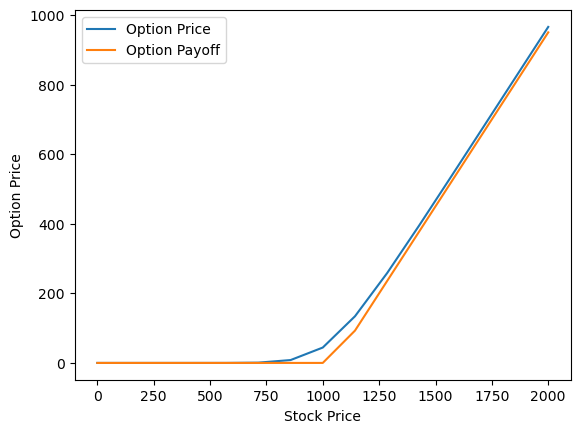

In [7]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025

price_bs = bs_price(S, K, r, T, sigma, option='call')

Call = AmCallEx(S, K, r, T, sigma, Smax, dS, dt)
Sv = Call[0]
f = Call[1]
price_fd = Call[2]

print('price_bs,', price_bs)
print('price_fd,', price_fd)

plt.plot(Sv, f, '-', label='Option Price')
plt.plot(Sv, np.maximum(Sv-K, 0), '-', label='Option Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.legend()

### American Put Option 

In [8]:
def AmPutEx(S, K, r, T, sigma, Smax, dS, dt):
    M = np.int_(np.round(Smax/dS))
    dS = Smax/M
    N = np.int_(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    V[:,-1] = np.maximum(K-Sv,0)
    V[0,:] = K*np.exp(-r*dt*(N-jv))
    V[M,:] = 0
    
    a = 0.5*dt*((sigma**2)*iv + r)*iv
    b = 1-dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv - r)*iv
    
    for j in reversed(np.arange(N)):
        for i in np.arange(1,M):
            early_exercise = K - Sv[i]
            continuation_value = (a[i]*V[i-1,j+1] + b[i]*V[i,j+1] + c[i]*V[i+1,j+1])
            V[i,j] = max(early_exercise, continuation_value)
    
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic')
    price = f_interp(S)
    return [Sv, V[:,0], price]

price_bs, 79.5298253471708
price_fd, 80.96225175400468


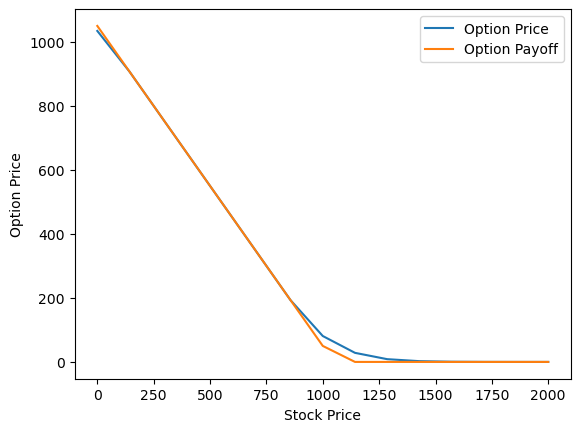

In [9]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025

price_bs_call = bs_price(S, K, r, T, sigma, option='put')
Put = AmPutEx(S, K, r, T, sigma, Smax, dS, dt)
Sv = Put[0]
f = Put[1]
price_fd = Put[2]

print('price_bs,', price_bs_call)
print('price_fd,', price_fd)

plt.plot(Sv, f, '-', label='Option Price')
plt.plot(Sv, np.maximum(K-Sv, 0), '-', label='Option Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.legend()

American Option value by Explicit Finite Difference Method for Call is <b> *44.19* </b> and for Put is <b> *80.96* </b>.

# Implicit Finite Difference Method-LU Decomposition

### American Call Option

In [11]:
def AmCallIm(S, K, r, T, sigma, Smax, dS, dt):
    M = int(np.round(Smax/dS))
    dS = Smax/M
    N = int(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    #Set up boundary conditions
    V[:,-1] = np.maximum(Sv-K,0)
    V[0,:] = 0
    V[M,:] = Smax - K*np.exp(-r*dt*(N-jv))
    
    # Set up tridiagonal coefficient matrix
    a = -0.5*dt*((sigma**2)*iv - r)*iv
    b = 1+dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv + r)*iv
    
    coef_mat =np.diag(a[2:M],-1)+np.diag(b[1:M])+np.diag(c[1:M-1],1)
    LU = lu_factor(coef_mat)
    
    bc = np.zeros(M-1)
    
    for j in reversed(np.arange(N)):
        bc[0] = -a[1]*V[0,j]
        bc[M-2] = -c[M-1]*V[M,j]
        
        # Solve linear system A*V[1:M-1,j] = b with LU
        V[1:M,j] = lu_solve(LU,V[1:M,j+1]+bc)
    
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation
    price = f_interp(S) # Scipy interpolation
    return [Sv, V[:,0], price]

price_bs, 45.162288763955075
price_fd, 44.07776954703448


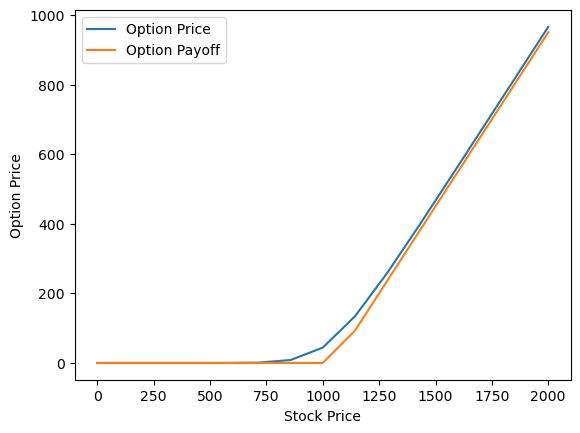

In [12]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025

price_bs_call = bs_price(S, K, r, T, sigma, option='call')
Call = AmCallIm(S, K, r, T, sigma, Smax, dS, dt)
Sv = Call[0]
f = Call[1]
price_fd = Call[2]

print('price_bs,', price_bs_call)
print('price_fd,', price_fd)

plt.plot(Sv, f, '-', label='Option Price')
plt.plot(Sv, np.maximum(Sv-K, 0), '-', label='Option Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.legend()

### American Put Option

In [13]:
def AmPutIm(S, K, r, T, sigma, Smax, dS, dt):
    M = np.int_(np.round(Smax/dS))
    dS = Smax/M
    N = np.int_(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    #Set up boundary conditions
    V[:,-1] = np.maximum(K-Sv,0)
    V[0,:] = K*np.exp(-r*dt*(N-jv))
    V[M,:] = 0

    # Set up tridiagonal coefficient matrix
    a = -0.5*dt*((sigma**2)*iv - r)*iv
    b = 1+dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv + r)*iv
    
    coef_mat =np.diag(a[2:M],-1)+np.diag(b[1:M])+np.diag(c[1:M-1],1)
    LU, C = la.lu_factor(coef_mat)
    bc = np.zeros(M-1)
    
    for j in reversed(np.arange(N)):
        bc[0] = -a[1]*V[0,j]
        bc[M-2] = -c[M-1]*V[M,j]
        
        # Solve linear system A*V[1:M-1,j] = b with LU
        V[1:M,j] = la.lu_solve((LU, C),V[1:M,j+1]+bc)
        
        f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation
        price = f_interp(S) # Scipy interpolation
    return [Sv, V[:,0], price]

price_bs, 79.5298253471708
price_fd, 78.44646966026644


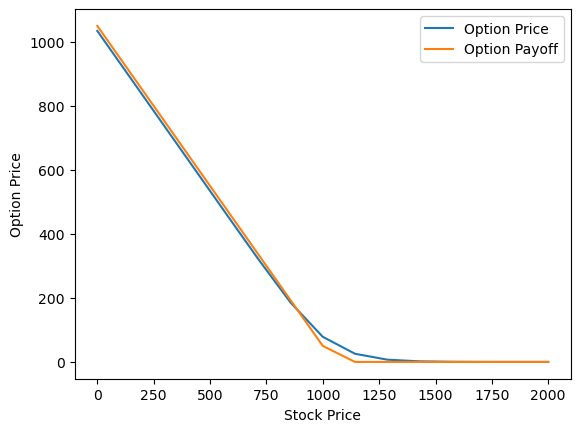

In [14]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025

price_bs_Put = bs_price(S, K, r, T, sigma, option='put')

Put = AmPutIm(S, K, r, T, sigma, Smax, dS, dt)
Sv = Put[0]
f = Put[1]
price_fd = Put[2]

print('price_bs,', price_bs_Put)
print('price_fd,', price_fd)

plt.plot(Sv, f, '-', label='Option Price')
plt.plot(Sv, np.maximum(K-Sv, 0), '-', label='Option Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.legend()

American Option Value by LU - Decomposition method for Call option is <b> *44.07* </b> whereas for Put option is <b> *78.44.* </b> 

#  Implicit Finite Difference Method-Gauss Seidel Method

In [15]:
def GaussSeidel(A, b, x0, epsil, MaxIter):
    x = x0
    N = len(b)
  
    for k in range(1,MaxIter):
        x_new = np.zeros(N)
        for i in range(N):
            s1 = np.dot(A[i, :i], x_new[:i])
            s2 = np.dot(A[i, i+1:], x[i+1:])
            x_new[i] = (b[i] - s1 - s2)/A[i,i]
        if np.allclose(x, x_new, rtol=epsil):
            break
        x=x_new    
    return x

### American Call Option

In [16]:
def AmCallGauss(S, K, r, T, sigma, Smax, dS, dt):
        M = int(np.round(Smax/dS))
        dS = Smax/M
        N = int(np.round(T/dt))
        dt = T/N
        V = np.zeros((M+1,N+1))
        Sv = np.linspace(0,Smax, M+1)
        iv = np.arange(M+1)
        jv = np.arange(N+1)
        
        #Set up boundary conditions
        V[:,-1] = np.maximum(Sv-K,0)
        V[0,:] = 0
        V[M,:] = np.maximum((Smax-K)*np.exp(-r*dt*(N-jv)),Smax-K)
        
        # Set up tridiagonal coefficient matrix
        a = -0.5*dt*((sigma**2)*iv - r)*iv
        b = 1+dt*((sigma**2)*(iv**2) + r)
        c = -0.5*dt*((sigma**2)*iv + r)*iv
        coef_mat =np.diag(a[2:M],-1)+np.diag(b[1:M])+np.diag(c[1:M-1],1)
        bc = np.zeros(M-1)
        
        for j in reversed(np.arange(N)):
            bc[0] = -a[1]*V[0,j]
            bc[M-2] = -c[M-1]*V[M,j]
            
            # Solve linear system A*V[1:M-1,j] = b with Gauss Seidel
            V[1:M, j] = GaussSeidel(coef_mat, V[1:M, j+1] + bc, np.zeros((M-1,1)), epsil, MaxIter)
            
            #Early exercise option in valuation 
            for m in range(0,M):
                V[m,j]=np.maximum(Sv[m]-K,V[m,j])

        f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation
        price = f_interp(S)
        return [Sv, V[:,0], price]

### American Put Option

In [17]:
 def AmPutGauss(S, K, r, T, sigma, Smax, dS, dt):
        M = int(np.round(Smax/dS))
        dS = Smax/M
        N = int(np.round(T/dt))
        dt = T/N
        V = np.zeros((M+1,N+1))
        Sv = np.linspace(0,Smax, M+1)
        iv = np.arange(M+1)
        jv = np.arange(N+1)
        
        #Set up boundary conditions
        V[:,-1] = np.maximum(K-Sv,0)
        V[0,:] = np.maximum((K)*np.exp(-r*dt*(N-jv)),K)
        V[M,:] = 0
        
        # Set up tridiagonal coefficient matrix
        a = -0.5*dt*((sigma**2)*iv - r)*iv
        b = 1+dt*((sigma**2)*(iv**2) + r)
        c = -0.5*dt*((sigma**2)*iv + r)*iv
        coef_mat =np.diag(a[2:M],-1)+np.diag(b[1:M])+np.diag(c[1:M-1],1)
        bc = np.zeros(M-1)
        
        for j in reversed(np.arange(N)):
            bc[0] = -a[1]*V[0,j]
            bc[M-2] = -c[M-1]*V[M,j]
            
            # Solve linear system A*V[1:M-1,j] = b with Gauss Seidel
            V[1:M, j] = GaussSeidel(coef_mat, V[1:M, j+1] + bc, np.zeros((M-1,1)), epsil, MaxIter)
            
            #Early exercise option in valuation 
            for m in range(0,M):
                V[m,j]=np.maximum(K-Sv[m],V[m,j])

        f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation
        price = f_interp(S) 
        return [Sv, V[:,0], price]

In [18]:
S       = 1000
K       = 1050
r       = 0.06
T       = 3/12
sigma   = 0.3
Smax    = 2000
dS      = 100
dt      = 0.0025
epsil   = 1e-6
MaxIter = 1000

Gauss_Seidel_Call = AmCallGauss(S, K, r, T, sigma, Smax, dS, dt)[2]
Gauss_Seidel_Put = AmPutGauss(S, K, r, T, sigma, Smax, dS, dt)[2]

print("American Call Option by Gauss Seidel: ", Gauss_Seidel_Call)
print("American Put Option by Gauss Seidel: ", Gauss_Seidel_Put)

American Call Option by Gauss Seidel:  45.101151802293316
American Put Option by Gauss Seidel:  80.98729536946352


By Gauss Seidel method American Call Option value is <b> *45.10* </b> and American Put Option value is <b> *80.98* </b>.

# Implicit Finite Difference Method-Gauss Seidel SOR Method

In [19]:
def SORGaussSeidel(A, b, x0, omega, epsil, MaxIter):
    x = x0
    N = len(b)
    for k in range(1,MaxIter):
        x_new = np.zeros(N)
        for i in range(N):
            s1 = np.dot(A[i, :i], x_new[:i])
            s2 = np.dot(A[i, i+1:], x[i+1:])
            z = (b[i] - s1 - s2)/A[i,i]
            x_new[i] = omega*z + (1-omega)*x[i]
        if np.allclose(x, x_new, rtol=epsil):
            break
        x = x_new
    return [x,k]

### American Call Option

In [20]:
def AmCallSOR(S, K, r, T, sigma, Smax, dS, dt, omega):
    M = int(np.round(Smax/dS))
    dS = Smax/M
    N = int(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    #Set up boundary conditions
    V[:,-1] = np.maximum(Sv-K,0)
    V[0,:] = 0
    V[M,:] = np.maximum((Smax-K)*np.exp(-r*dt*(N-jv)),Smax-K)
    
    # Set up tridiagonal coefficient matrix
    a = -0.5*dt*((sigma**2)*iv - r)*iv
    b = 1+dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv + r)*iv
    coef_mat =np.diag(a[2:M],-1)+np.diag(b[1:M])+np.diag(c[1:M-1],1)
    bc = np.zeros(M-1)
    
    for j in reversed(np.arange(N)):
        bc[0] = -a[1]*V[0,j]
        bc[M-2] = -c[M-1]*V[M,j]
        # Solve linear system A*V[1:M-1,j] = b with Gauss Seidel
        V[1:M,j] = SORGaussSeidel(coef_mat,V[1:M,j+1]+bc,np.zeros((M-1,1)),omega,epsil,MaxIter)[0]
        #We include the early exercise option in the valuation 
        for m in np.arange(0,M):
            V[m,j]=np.maximum(Sv[m]-K,V[m,j])

    f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation
    price = f_interp(S) # Scipy interpolation
    return [price,SORGaussSeidel(coef_mat,V[1:M,j+1]+bc,np.zeros((M-1,1)),omega,epsil,MaxIter)[1]]

### American Put Option

In [21]:
def AmPutSOR(S, K, r, T, sigma, Smax, dS, dt,omega):
        M = int(np.round(Smax/dS))
        dS = Smax/M
        N = int(np.round(T/dt))
        dt = T/N
        V = np.zeros((M+1,N+1))
        Sv = np.linspace(0,Smax, M+1)
        iv = np.arange(M+1)
        jv = np.arange(N+1)
        
        #Set up boundary conditions
        V[:,-1] = np.maximum(K-Sv,0)
        V[0,:] = np.maximum((K)*np.exp(-r*dt*(N-jv)),K)
        V[M,:] = 0
        
        # Set up tridiagonal coefficient matrix
        a = -0.5*dt*((sigma**2)*iv - r)*iv
        b = 1+dt*((sigma**2)*(iv**2) + r)
        c = -0.5*dt*((sigma**2)*iv + r)*iv
        coef_mat =np.diag(a[2:M],-1)+np.diag(b[1:M])+np.diag(c[1:M-1],1)
        bc = np.zeros(M-1)
        
        for j in reversed(np.arange(N)):
            bc[0] = -a[1]*V[0,j]
            bc[M-2] = -c[M-1]*V[M,j]
            # Solve linear system A*V[1:M-1,j] = b with Gauss Seidel
            V[1:M,j] = SORGaussSeidel(coef_mat,V[1:M,j+1]+bc,np.zeros((M-1,1)),omega,epsil,MaxIter)[0]
            #We include the early exercise option in the valuation 
            for m in range(0,M):
                V[m,j]=np.maximum(K-Sv[m],V[m,j])

        f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation
        price = f_interp(S) # Scipy interpolation
        return [price,SORGaussSeidel(coef_mat,V[1:M,j+1]+bc,np.zeros((M-1,1)),omega,epsil,MaxIter)[1]]

In [22]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025
omega = 1

Gauss_SeidelSOR_Call = AmCallSOR(S, K, r, T, sigma, Smax, dS, dt, omega)
Gauss_SeidelSOR_Put = AmPutSOR(S, K, r, T, sigma, Smax, dS, dt, omega)

print("American Call Option by Gauss Seidel: ", Gauss_SeidelSOR_Call)
print("American Put Option by Gauss Seidel: ", Gauss_SeidelSOR_Put)

American Call Option by Gauss Seidel:  [array(44.07742302), 5]
American Put Option by Gauss Seidel:  [array(80.09312237), 4]


American Option value by Gauss Seidel SOR method for Call Option value is <b> *44.07* </b> and American Put Option value is <b> *80.09* </b>.

# Question 2: American Options with Dividend

## Binomial Method

In [23]:
def binomialAmericanOption_Dividend(S, K, r, T, sigma, div, t_div, n=100, option='call'):
    deltaT = T/n
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1.0 / u
    a = np.exp((r-div)*deltaT)
    q = (a-d) / (u-d)
    Sv = np.zeros((n+1,n+1))
    V = np.zeros((n+1,n+1))
    
    # Build stock price matrix forward
    for j in range(n+1):
        for i in range(j+1):
            Sv[i,j] = S * (u**i) * (d**(j-i))
            # subtract present value of dividends from stock price
            if t_div > j * deltaT:
                Sv[i,j] -= div * np.exp(-r * (t_div - j * deltaT))
            
    if option == 'call':
        CorP = 1
    elif option == 'put':
        CorP = -1
        V[:,-1] = np.maximum((Sv[:,-1]-K)*CorP,0)
   
    # Price option with backward induction
    for j in reversed(range(n)):
        for i in range(j+1):
            V[i,j] = np.exp(-r*deltaT) * (q*V[i+1,j+1] + (1.0-q)*V[i,j+1])
            V[i,j] = np.maximum(V[i,j], (Sv[i,j]-K)*CorP)
    
            # check if it's optimal to exercise early
            if option == 'put':
                V[i,j] = max(V[i,j], K - Sv[i,j])
            else:
                V[i,j] = max(V[i,j], Sv[i,j] - K)                
    return V[0,0]

### Dividend -  4% 

In [24]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
div   = 0.04
t_div = T/2

BMC_div=binomialAmericanOption_Dividend(S, K, r, T, sigma, div, t_div, n=100, option='call')
BMP_div=binomialAmericanOption_Dividend(S, K, r, T, sigma, div, t_div, n=100, option='put')

print("Binomial Method for American Call Option with Dividend: ",BMC_div)
print("Binomial method for American Put Option with Dividend: ",BMP_div)

Binomial Method for American Call Option with Dividend:  40.58174231864723
Binomial method for American Put Option with Dividend:  86.2143325880707


### Dividend - 10%

In [25]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
div   = 0.10
t_div = T/2

BMC_div=binomialAmericanOption_Dividend(S, K, r, T, sigma, div, t_div, n=100, option='call')
BMP_div=binomialAmericanOption_Dividend(S, K, r, T, sigma, div, t_div, n=100, option='put')

print("Binomial Method for American Call Option with Dividend: ",BMC_div)
print("Binomial method for American Put Option with Dividend: ",BMP_div)

Binomial Method for American Call Option with Dividend:  35.38810896825042
Binomial method for American Put Option with Dividend:  94.26837928980662


## Explicit Finite Difference Method

### American Call Option  with Dividend

In [26]:
def AmCallEx_Dividend(S, K, r, T, sigma, Smax, dS, dt, div):
    M = np.int_(np.round(Smax/dS))
    dS = Smax/M
    N = np.int_(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    V[:,-1] = np.maximum(Sv-K,0)
    V[0,:] = 0
    V[M,:] = Smax - K*np.exp(-r*dt*(N-jv))
    
    a = 0.5*dt*((sigma**2)*iv - (r-div))*iv
    b = 1-dt*((sigma**2)*(iv**2) + (r-div))
    c = 0.5*dt*((sigma**2)*iv + (r-div))*iv
    
    for j in reversed(np.arange(N)):
        for i in np.arange(1,M):
            Sv_div = Sv[i] - div * np.exp(-r * (N-j) * dt)
            V[i,j] = a[i]*V[i-1,j+1]+b[i]*V[i,j+1]+c[i]*V[i+1,j+1]
            V[i,j] = np.maximum(V[i,j], Sv_div-K)
            V[i,j] = np.maximum(V[i,j], (a[i]+b[i]+c[i])*V[i,j+1])
            
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation    
    price = f_interp(S)
    return [Sv, V[:,0], price]

price_fd, 40.26310672113602


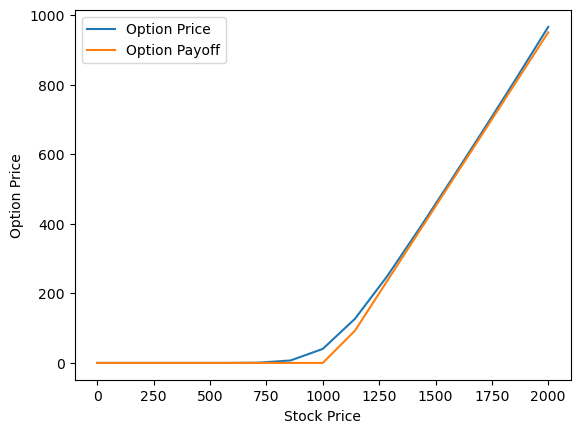

In [27]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025
div   = 0.04

Call = AmCallEx_Dividend(S, K, r, T, sigma, Smax, dS, dt, div)
Sv = Call[0]
f = Call[1]
price_fd = Call[2]

print('price_fd,', price_fd)

plt.plot(Sv, f, '-', label='Option Price')
plt.plot(Sv, np.maximum(Sv-K, 0), '-', label='Option Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.legend()

### American Put Option with Dividend

In [28]:
def AmPutEx_Dividend(S, K, r, T, sigma, Smax, dS, dt, div):
    M = np.int_(np.round(Smax/dS))
    dS = Smax/M
    N = np.int_(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    V[:,-1] = np.maximum(K-Sv,0)
    V[0,:] = K*np.exp(-r*dt*(N-jv))
    V[M,:] = 0
    
    a = 0.5*dt*((sigma**2)*iv - (r-div))*iv
    b = 1-dt*((sigma**2)*(iv**2) + (r-div))
    c = 0.5*dt*((sigma**2)*iv + (r-div))*iv
    
    for j in reversed(np.arange(N)):
        for i in np.arange(1,M):
            Sv_div = Sv[i] - div * np.exp(-r * (N-j) * dt)
            V[i,j] = a[i]*V[i-1,j+1]+b[i]*V[i,j+1]+c[i]*V[i+1,j+1]
            V[i,j] = np.maximum(V[i,j], K-Sv_div)
            V[i,j] = np.maximum(V[i,j], (a[i]+b[i]+c[i])*V[i,j+1])
            
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation    
    price = f_interp(S)
    return [Sv, V[:,0], price]

price_fd, 85.31501993751996


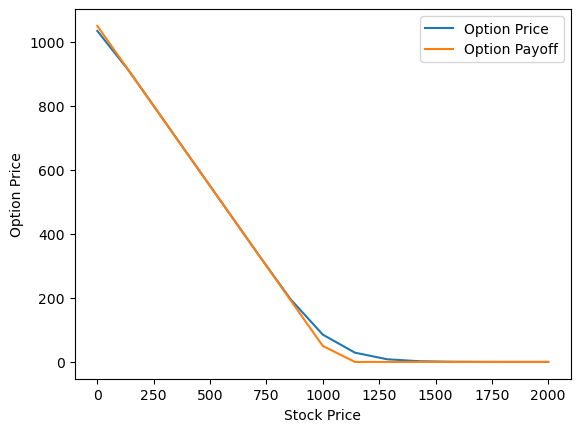

In [29]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025
div   = 0.04

Put = AmPutEx_Dividend(S, K, r, T, sigma, Smax, dS, dt, div)
Sv = Put[0]
f = Put[1]
price_fd = Put[2]

print('price_fd,', price_fd)

plt.plot(Sv, f, '-', label='Option Price')
plt.plot(Sv, np.maximum(K-Sv, 0), '-', label='Option Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.legend()

### American Call Option

### Americal Call Option - Gauss Seidel Method

In [38]:
def AmcallIm_GS_Div2(S, K, r, T, sigma, Smax, dS, dt):
    
    M = np.int64(np.round(Smax/dS))
    dS = Smax/M
    N = np.int64(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    div=0.1                                     # Dividend of 4% assumed at the middle of time frame
    
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    # Set up boundary conditions
    V[:,-1] = np.maximum(Sv*(1-div)-K,0)         # The boundary condition is adjusted for dividend
    V[0,:] = 0
    V[M,:] = Smax-K*np.exp(-r*dt*(N-jv))
    
    # Set up tridiagonal coefficient matrix
    a = -0.5*dt*((sigma**2)*iv - r)*iv
    b = 1+dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv + r)*iv
    
    coef_mat = np.diag(a[2:M],-1) + np.diag(b[1:M]) + np.diag(c[1:M-1],1)
    bc = np.zeros(M-1)
    x0 = np.zeros(M-1)
    A = coef_mat
    
    for j in reversed(np.arange(N)):
        bc[0] = -a[1]*V[0,j]
        bc[-1] = -c[-2]*V[M,j] 
        B = V[1:M, j+1] + bc
        x_new = GaussSeidel(A,B,x0,1e-8,1000)
        
        # Converting list to numpy array
        x_new = np.array(x_new)
        
        V[1:M, j] = np.maximum(x_new, Sv[1:M]*(1-div)-K) if j > (N/2) else np.maximum(x_new, Sv[1:M]-K)
        
    f_interp = interp1d(Sv, V[:,0], kind = "cubic") # Scipy interpolation
    price = f_interp(S) # Scipy interpolation
    return [Sv, V[:,0], price]

### Dividend - 4% 

In [39]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025
div   = 0.04
t_div = T/2

AOC   =  AmcallIm_GS_Div2(S, K, r, T, sigma, Smax, dS, dt)[2]

print("American Call Option by Gauss Seidel Method(Dividend-4%): ",AOC)

American Call Option by Gauss Seidel Method(Dividend-4%):  27.34062083266842


### Dividend - 10% 

In [40]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025
div   = 0.10
t_div = T/2

AOC   =  AmcallIm_GS_Div2(S, K, r, T, sigma, Smax, dS, dt)[2]

print("American Call Option by Gauss Seidel Method(Dividend-10%): ",AOC)

American Call Option by Gauss Seidel Method(Dividend-10%):  27.34062083266842


### American Put Option - Gauss Seidel Method 

In [41]:
import numpy as np
from scipy.interpolate import interp1d

def AmPUTIm_GS_Div2(S, K, r, T, sigma, Smax, dS, dt):
    
    M = np.int64(np.round(Smax/dS))
    dS = Smax/M
    N = np.int64(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))                                    
    
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    # Set up boundary conditions
    V[:,-1] = np.maximum(K-Sv*(1-div),0)
    V[0,:] = 0
    V[M,:] = K*np.exp(-r*dt*(N-jv))
    
    # Set up tridiagonal coefficient matrix
    a = -0.5*dt*((sigma**2)*iv - r)*iv
    b = 1+dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv + r)*iv
    
    coef_mat = np.diag(a[2:M],-1) + np.diag(b[1:M]) + np.diag(c[1:M-1],1)
    bc = np.zeros(M-1)
    x0 = np.zeros(M-1)
    A = coef_mat
    
    for j in reversed(np.arange(N)):
        bc[0] = -a[1]*V[0,j]
        bc[-1] = -c[-2]*V[M,j] 
        B = V[1:M, j+1] + bc
        x_new = GaussSeidel(A,B,x0,1e-8,1000)
        
        # Converting list to numpy array
        x_new = np.array(x_new)
        
        V[1:M, j] = np.maximum(x_new, K-Sv[1:M]*(1-div)) if j > (N/2) else np.maximum(x_new, K-Sv[1:M])
        
    f_interp = interp1d(Sv, V[:,0], kind = "cubic") # Scipy interpolation
    price = f_interp(S) # Scipy interpolation
    return [Sv, V[:,0], price]

### Dividend 4% 

In [42]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025
div   = 0.04
t_div = T/2

AOP   =  AmPUTIm_GS_Div2(S, K, r, T, sigma, Smax, dS, dt)[2]

print("American Put Option by Gauss Seidel Method(Dividend-4%): ",AOP)

American Put Option by Gauss Seidel Method(Dividend-4%):  106.06931789033737


### Dividend 10%

In [43]:
S     = 1000
K     = 1050
r     = 0.06
T     = 3/12
sigma = 0.3
Smax  = 2000
dS    = 140
dt    = 0.0025
div   = 0.10
t_div = T/2

AOP   =  AmPUTIm_GS_Div2(S, K, r, T, sigma, Smax, dS, dt)[2]

print("American Put Option by Gauss Seidel Method(Dividend-10%): ",AOP)

American Put Option by Gauss Seidel Method(Dividend-10%):  151.3014973351519
